---
# <span style="color: #4169E1">**Global Tech Layoffs Analysis (2020-2024)**</span>

## <span style="color: #4169E1">**Project number 10**</span>

### <span style="color: #4169E1">Names of students:</span>  
<span style="color: #4169E1">Miriam Dinay</span><br>
<span style="color: #4169E1">Roni Shapiro</span><br>



---

#### <span style="color: #4169E1">**Project description**</span>
<span style="color: #4169E1">1-3 lines describing your project</span><br>

#### <span style="color: #4169E1">**Project description:**</span>
The dataset contains information about reported worldwide layoffs in tech companies between 2020-2024.
[link to the data source](https://www.kaggle.com/datasets/ulrikeherold/tech-layoffs-2020-2024)

<a id="intro"></a>
<h3 style="color: #4169E1; background-color: #f0f4ff; padding: 10px; border-right: 5px solid #4169E1; text-align: right; direction: rtl;">פתיחה והכרות עם הנתונים</h3>

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
url='https://raw.githubusercontent.com/MiriamDinay/Layoff-Trends/main/tech_layoffs.csv'
Layoff_df=pd.read_csv(url)
Layoff_df.head()

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200.0,2023-12-20,15.0,1333.0,1133.0,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100.0,2023-12-19,20.0,500.0,400.0,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350.0,2023-12-18,10.0,3500.0,3150.0,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100.0,2023-12-18,10.0,1000.0,900.0,Retail,Unknown,NaN,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900.0,2023-12-14,24.0,3750.0,2850.0,Transportation,Acquired,$15000,2023,37.77493,-122.41942


In [40]:
Layoff_df.shape

(1672, 16)

In [41]:
Layoff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672 entries, 0 to 1671
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   #                            1672 non-null   int64  
 1   Company                      1672 non-null   object 
 2   Location_HQ                  1672 non-null   object 
 3   Country                      1672 non-null   object 
 4   Continent                    1672 non-null   object 
 5   Laid_Off                     1565 non-null   float64
 6   Date_layoffs                 1672 non-null   object 
 7   Percentage                   1570 non-null   float64
 8   Company_Size_before_Layoffs  1511 non-null   float64
 9   Company_Size_after_layoffs   1536 non-null   float64
 10  Industry                     1672 non-null   object 
 11  Stage                        1672 non-null   object 
 12  Money_Raised_in_$_mil        1596 non-null   object 
 13  Year              

In [42]:
# לשים לב לכתוב על מחיקת השורות שאנחנו לא צריכים למחקר. אחר כך נרשום הכל בצורה מסודרת
Layoff_df_copy = Layoff_df.copy()
Layoff_df_copy['Date_layoffs'] = pd.to_datetime(Layoff_df_copy['Date_layoffs'])
Layoff_df_copy['Money_Raised_in_$_mil'] = (Layoff_df_copy['Money_Raised_in_$_mil'].astype(str).str.replace(r'[$,]', '', regex=True))
Layoff_df_copy['Money_Raised_in_$_mil'] = pd.to_numeric(Layoff_df_copy['Money_Raised_in_$_mil'],errors='coerce')
Layoff_df_copy['#'] = Layoff_df_copy['#'].astype(str)
Layoff_df_copy = Layoff_df_copy.drop(columns=['lat', 'lng',])
Layoff_df_copy.dtypes

#                                      object
Company                                object
Location_HQ                            object
Country                                object
Continent                              object
Laid_Off                              float64
Date_layoffs                   datetime64[ns]
Percentage                            float64
Company_Size_before_Layoffs           float64
Company_Size_after_layoffs            float64
Industry                               object
Stage                                  object
Money_Raised_in_$_mil                 float64
Year                                    int64
dtype: object

In [43]:
# בדיקה אם יש הבדלים בשנה והאם אפשר לסמוך על העמודה הזאת
mismatch = Layoff_df_copy[Layoff_df_copy['Date_layoffs'].dt.year != Layoff_df_copy['Year']]
mismatch.shape

(37, 14)

In [44]:
# דריסת עמודת השנה המקורית בשנה המדויקת מהתאריך
Layoff_df_copy['Year'] = Layoff_df_copy['Date_layoffs'].dt.year

In [45]:
Layoff_df_copy.isnull().sum().sort_values(ascending=False)

Company_Size_before_Layoffs    161
Company_Size_after_layoffs     136
Laid_Off                       107
Percentage                     102
Money_Raised_in_$_mil           76
#                                0
Continent                        0
Country                          0
Location_HQ                      0
Company                          0
Date_layoffs                     0
Industry                         0
Stage                            0
Year                             0
dtype: int64

<p dir="rtl" style="text-align: right; color: black; line-height: 1.8;">
בחרנו לבצע המרת טיפוסי נתונים לפני ניקוי שורות כדי לשמר את שלמות בסיס הנתונים המקורי. ערכים חסרים לא הושלמו באופן מלאכותי כדי למנוע הטיה בניתוח חומרת הפיטורין וגודל החברות</p>







In [46]:
# 4. ניקוי שורות שאין בהן מידע על פיטורין בכלל (כמות או אחוז)
# זהו השלב שבו אנחנו מוודאים שכל שורה ב-Dataset יכולה לתרום למחקר
Layoff_df_copy = Layoff_df_copy.dropna(subset=['Laid_Off', 'Percentage'], how='all')

# 5. בקרת איכות (Sanity Check) - השוואת הפרשי גדלים לכמות המפוטרים
# הבדיקה מתבצעת רק היכן שכל שלושת הנתונים קיימים במקור
mask = (Layoff_df_copy['Company_Size_before_Layoffs'].notna() &Layoff_df_copy['Company_Size_after_layoffs'].notna() &Layoff_df_copy['Laid_Off'].notna())
Layoff_df_copy.loc[mask, 'size_diff_check'] = (Layoff_df_copy['Company_Size_before_Layoffs'] -Layoff_df_copy['Company_Size_after_layoffs'] -Layoff_df_copy['Laid_Off'])

# הצגת סיכום הנתונים לאחר הניקוי
print(f"Total rows after cleaning: {len(Layoff_df_copy)}")
print(Layoff_df_copy.dtypes)

Total rows after cleaning: 1624
#                                      object
Company                                object
Location_HQ                            object
Country                                object
Continent                              object
Laid_Off                              float64
Date_layoffs                   datetime64[ns]
Percentage                            float64
Company_Size_before_Layoffs           float64
Company_Size_after_layoffs            float64
Industry                               object
Stage                                  object
Money_Raised_in_$_mil                 float64
Year                                    int32
size_diff_check                       float64
dtype: object


In [47]:
inconsistent_rows = Layoff_df_copy[Layoff_df_copy['size_diff_check'] != 0].shape[0]
print(f"Number of rows with inconsistencies: {inconsistent_rows}")

Number of rows with inconsistencies: 114


מהפער שנמצא ב-114 רשומות ניתן להסיק ששינויים במצבת כוח האדם מושפעים מגורמים נוספים מלבד פיטורים מוכרזים, כגון עזיבה מרצון או שינויים ארגוניים פנימיים. לכן, שמירה על הנתונים המקוריים מבטיחה ניתוח אובייקטיבי יותר

In [48]:
(Layoff_df_copy.loc[mask, 'size_diff_check'] == 0).mean()

np.float64(0.99933818663137)

<div dir="rtl" style="text-align: right;">
<ul style="list-style-type: none; padding-right: 20px;">
  <li>
    <a href="#theory" style="text-decoration: none; color: #4169E1;"><b>יצרנו העתק של קובץ הנתונים המקורי, סידרנו אותם וסיווגנו את "טיפוסי" העמודות.</b></a>
  </li>
  <li>
      <a href="#theory" style="text-decoration: none; color: #4169E1;"><b>מעתה, בהמשך העבודה נעבוד על קובץ ההעתק בלבד.</b></a>
  </li>
  <li>

In [49]:
Layoff_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1624 entries, 0 to 1671
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   #                            1624 non-null   object        
 1   Company                      1624 non-null   object        
 2   Location_HQ                  1624 non-null   object        
 3   Country                      1624 non-null   object        
 4   Continent                    1624 non-null   object        
 5   Laid_Off                     1565 non-null   float64       
 6   Date_layoffs                 1624 non-null   datetime64[ns]
 7   Percentage                   1570 non-null   float64       
 8   Company_Size_before_Layoffs  1511 non-null   float64       
 9   Company_Size_after_layoffs   1536 non-null   float64       
 10  Industry                     1624 non-null   object        
 11  Stage                        1624 non-null   obj

### שאלה ראשונה

<h4 style="color: #4169E1; text-align: right; direction: rtl;">1.1 סיכום פיטורים שנתי (2020-2024)</h4>
<p dir="rtl" style="text-align: right;">
גרף זה מציג את סך המפוטרים בכל שנה.</p>

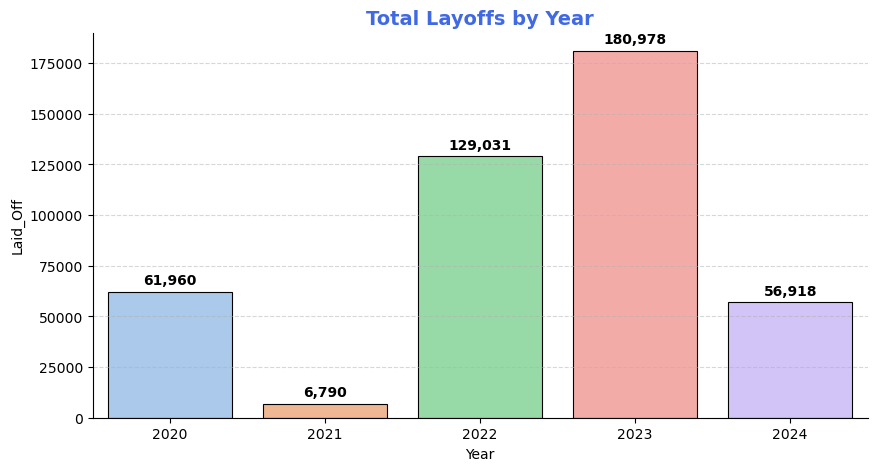

In [50]:
plt.figure(figsize=(10, 5))
yearly_layoffs = Layoff_df_copy.groupby('Year')['Laid_Off'].sum().reset_index()

sns.barplot(data=yearly_layoffs, x='Year', y='Laid_Off', palette='pastel', edgecolor='black', linewidth=0.8, hue='Year', legend=False)
plt.title('Total Layoffs by Year', fontsize=14, color='#4169E1', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, val in enumerate(yearly_layoffs['Laid_Off']):
    plt.text(i, val + (yearly_layoffs['Laid_Off'].max() * 0.02), f'{int(val):,}', ha='center', fontweight='bold')

sns.despine()
plt.show()

<p dir="rtl" style="text-align: right; color: black; margin-top: 10px;">
ניתן לראות כי שנת 2023 בולטת כשנת שיא דרמטית, עם גידול של כ- 40% בהיקף פיטורים מהשנה שקדמה לה.</p>

<h4 style="color: #4169E1; text-align: right; direction: rtl;">1.2 מגמות רבעוניות - ציר זמן</h4>
<p dir="rtl" style="text-align: right;">
כאן אנו יורדים לרמת הרבעון כדי להבין מתי בדיוק התרחשו הזינוקים המשמעותיים.
</p>

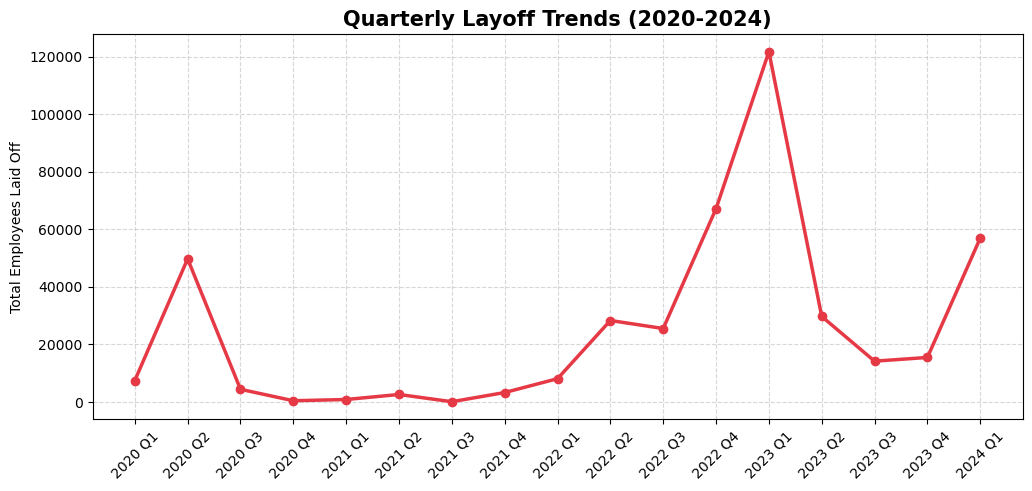

The 3 Most Significant Peaks:


,Quarter_Display,Total_Laid_Off
12,2023 Q1,121667.0
11,2022 Q4,67152.0
16,2024 Q1,56918.0


In [54]:
# 1. יצירת עמודת הרבעון המקורית (כדי לשמור על הסדר הכרונולוגי)
Layoff_df_copy['Quarter_Period'] = Layoff_df_copy['Date_layoffs'].dt.to_period('Q')

# 2. יצירת סיכום רבעוני
qtr_summary = (Layoff_df_copy.loc[Layoff_df_copy['Date_layoffs'].dt.year.between(2020, 2024)].groupby('Quarter_Period').agg(Total_Laid_Off=('Laid_Off', 'sum'),Layoff_Events=('#', 'count')).reset_index())

# 3. שינוי הנראות מ-2020Q1 ל-2020 Q1 (הוספת רווח לפני ה-Q)
# אנחנו הופכים את זה לטקסט ומשתמשים ב-replace כדי להוסיף רווח
qtr_summary['Quarter_Display'] = qtr_summary['Quarter_Period'].astype(str).str.replace('Q', ' Q')

# --- Step 1.2: Visualizing the Trend ---
plt.figure(figsize=(12, 5))
plt.plot(qtr_summary['Quarter_Display'], qtr_summary['Total_Laid_Off'], marker='o', linestyle='-', color='#e63946', linewidth=2.5)
plt.title('Quarterly Layoff Trends (2020-2024)', fontsize=15, fontweight='bold')
plt.ylabel('Total Employees Laid Off')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Step 1.3: Top 3 Peaks ---
top_3_peaks = qtr_summary.sort_values('Total_Laid_Off', ascending=False).head(3)
print("The 3 Most Significant Peaks:")
display(top_3_peaks[['Quarter_Display', 'Total_Laid_Off']])

<h4 style="color: #4169E1; text-align: right; direction: rtl;">1.3 התפלגות עוצמת הפיטורים (Boxplot)</h4>
<p dir="rtl" style="text-align: right;">
 ניתן לראות את הפיזור של כל אירוע פיטורים בנפרד. זה עוזר לנו להבין האם רבעון מסוים היה קשה בגלל הרבה אירועים קטנים, או בגלל מספר מצומצם של "פיטורי ענק".
</p>

In [ ]:
# --- שלב 2: ניתוח עונתיות ללא אזהרות ---
plt.figure(figsize=(10, 6))

quarter_data = Layoff_df_copy['Date_layoffs'].dt.quarter

sns.boxplot(data=Layoff_df_copy.dropna(subset=['Laid_Off']), x=quarter_data, y='Laid_Off', hue=quarter_data, legend=False,      palette='pastel', showfliers=False)

sns.stripplot(data=Layoff_df_copy.dropna(subset=['Laid_Off']), x=quarter_data, y='Laid_Off', color='black', size=3, alpha=0.3)

plt.yscale('log')
plt.title('Seasonality Analysis: Layoff Distribution by Quarter (2020-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Quarter Number (1-4)')
plt.ylabel('Layoffs per Event (Log Scale)')
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()



In [ ]:
# --- שלב 3: מפת חום - עוצמת פיטורים לפי תעשייה וזמן ---
Layoff_df_copy['Date_layoffs'] = pd.to_datetime(Layoff_df_copy['Date_layoffs'], errors='coerce')
Layoff_df_copy['Laid_Off'] = pd.to_numeric(Layoff_df_copy['Laid_Off'], errors='coerce')

Layoff_df_copy['Quarter_Period'] = Layoff_df_copy['Date_layoffs'].dt.to_period('Q')
Layoff_df_copy['Quarter_Display'] = Layoff_df_copy['Quarter_Period'].astype(str).str.replace('Q', ' Q', regex=False)
heat_df = Layoff_df_copy.dropna(subset=['Industry', 'Quarter_Display', 'Laid_Off']).copy()

# 1) מטריצה
industry_heatmap_df = (heat_df.groupby(['Industry', 'Quarter_Display'])['Laid_Off'].sum().unstack(fill_value=0))
industry_heatmap_df = industry_heatmap_df.reindex(sorted(industry_heatmap_df.columns), axis=1)
top_industries = heat_df.groupby('Industry')['Laid_Off'].sum().nlargest(10).index
industry_heatmap_df = industry_heatmap_df.loc[top_industries]
plt.figure(figsize=(16, 8))
sns.heatmap(industry_heatmap_df,annot=True,fmt=".0f",cmap="YlOrRd",linewidths=.5,cbar_kws={'label': 'Total Employees Laid Off'})

plt.title('Layoff Intensity: Top 10 Industries over Time (2020-2024)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Industry', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<div dir="rtl" style="text-align: right;">
ניתוח הנתונים מעלה כי התנודתיות בשוק הגיעה לשיאה הדרמטי ברבעון הראשון של 2023. נמצא כי קיים דפוס עונתי עקבי שבו רבעון 1 מרכז את אירועי הפיטורים. השיא של 2023 התאפיין מגמה רוחבית שפגעה בכלל ענפי הטכנולוגיה, כפי שמשתקף בזינוק בקטגוריית ה-Other ובסקטורים הצרכניים. תמהיל זה מסמן מעבר משיבושים ענפיים נקודתיים לתיקון כלכלי רחב היקף המשפיע על המערכת כולה

### Question 2:

<div dir="rtl" style="text-align: right;">
בשלב זה אנו בוחנים האם קיים קשר בין רמת הבשלות של החברה (מסטארט-אפ בתחילת הדרך ועד חברה ציבורית) לבין אופי הפיטורים.
    

<h4 style="color: #4169E1; text-align: right; direction: rtl;">שלב 2.1: הכנת הנתונים וסידור היררכי</h4>
<p dir="rtl" style="text-align: right;">

In [ ]:
# --- Step 2.1: Data Preparation & Ordered Categorical Definition ---

# 1. Filtering rows with required data for this question
stage_analysis_df = Layoff_df_copy.dropna(subset=['Stage', 'Laid_Off', 'Percentage']).copy()

# 2. Defining the logical master order (from earliest to most mature)
master_stage_order = ['Seed', 'Series A', 'Series B', 'Series C', 'Series D', 'Series E', 'Series F', 'Series G', 'Series H', 'Series I', 'Series J', 'Private Equity', 'Acquired', 'Post-IPO', 'Unknown']

# 3. Filtering the master order to include ONLY stages present in the data
# This ensures plots remain wide and focused
existing_stages = [s for s in master_stage_order if s in stage_analysis_df['Stage'].unique()]

# 4. Setting the 'Stage' column as an ordered categorical type
stage_analysis_df['Stage'] = pd.Categorical(stage_analysis_df['Stage'], categories=existing_stages, ordered=True)

# 5. Calculating summary statistics (Frequency and Severity)
# The order is automatically preserved due to the categorical type
stage_stats = stage_analysis_df.groupby('Stage', observed=False).agg(
    Frequency=('#', 'count'),
    Total_Laid_Off=('Laid_Off', 'sum'),
    Median_Percentage=('Percentage', 'median')).reset_index()

<h4 style="color: #4169E1; text-align: right; direction: rtl;">שלב 2.2: השוואת תדירות הפיטורים מול כמות המפוטרים הכוללת</h4>
<p dir="rtl" style="text-align: right;">

<p style="text-align:right; direction:rtl;">
בגרף זה אנו משלבים שני צירים (Dual Axis):
</p>

<ul style="text-align:right; direction:rtl; padding-right:20px;">
  <li>
    <strong>העמודות:</strong>
    מייצגות את מספר הפעמים שחברות בכל שלב ביצעו פיטורים.
  </li>
  <li>
    <strong>הקו:</strong>
    מייצג את כמות האנשים המצטברת שפוטרה בכל שלב.
  </li>
</ul>

<p style="text-align:right; direction:rtl;">
המטרה שלנו הייתה לזהות האם שלב מסוים אחראי ל״מסה״ העיקרית של המפוטרים בשוק.
</p>


In [ ]:
# --- Step 2.2: Visualizing Frequency vs. Absolute Severity ---

fig, ax1 = plt.subplots(figsize=(13, 6))

# Bar chart for Frequency
sns.barplot(data=stage_stats, x='Stage', y='Frequency', palette='viridis', ax=ax1, hue='Stage', legend=False)
ax1.set_ylabel('Number of Layoff Events (Frequency)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Company Stage', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)

# Twin axis for Total Laid Off (Line plot)
ax2 = ax1.twinx()
sns.lineplot(data=stage_stats, x='Stage', y='Total_Laid_Off', marker='o', color='red', ax=ax2, label='Total Laid Off', linewidth=2)
ax2.set_ylabel('Total Employees Laid Off (Absolute Severity)', fontsize=12, fontweight='bold', color='red')

plt.title('Layoff Frequency vs. Absolute Severity by Company Stage', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

<h4 style="color: #4169E1; text-align: right; direction: rtl;">שלב 2.3: ניתוח חומרה יחסית (אחוז המפוטרים)</h4>
<p dir="rtl" style="text-align: right;">
לאחר שראינו באיזה שלב קורים הרבה פיטורים, אנו בוחנים את "עומק הפגיעה". השתמשנו ב-Boxplot כדי לראות את התפלגות אחוזי הפיטורים. גרף זה מאפשר לנו לזהות האם בחברות קטנות הפיטורים נוטים להיות מסיביים יותר ביחס לגודלן 

In [ ]:
# --- Step 2.3: Visualizing Relative Severity (Workforce Percentage) ---
plt.figure(figsize=(13, 6))
# Boxplot of Layoff Percentages
sns.boxplot(data=stage_analysis_df, x='Stage', y='Percentage', palette='Set3', showfliers=False, hue='Stage', legend=False)
plt.title('Layoff Percentage Distribution by Company Stage', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Workforce Laid Off (%)', fontsize=12)
plt.xlabel('Company Stage', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

stage_stats.style.format({
    'Total_Laid_Off': '{:,.0f}',      # מספרים שלמים עם פסיק לאלפים (למשל 120,500)
    'Median_Percentage': '{:.1f}%'    # ספרה אחת אחרי הנקודה וסימן אחוז (למשל 15.5%)
}).background_gradient(cmap='Blues', subset=['Frequency', 'Total_Laid_Off']).set_caption("Summary Statistics: Company Stage Comparison")

#### Reference: Understanding Company Stages
To provide context for the ordered analysis above, the stages are categorized as follows:
* **Early Stage (Seed, Series A):** Initial funding phases for product development and early market entry.
* **Growth Stage (Series B through H):** Scaling phases where companies expand their market share and operations.
* **Late/Mature Stage (Private Equity, Acquired, Post-IPO):** Established companies that have either been bought, are managed by private investors, or are publicly traded on the stock market.